In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize # from scipy.misc import imresize
from tqdm import tqdm
import nibabel

In [4]:
def read_train_exam(exam_nb):
    image = nibabel.load('../chaos/train/%02d-T2SPIR-src.nii.gz'%(exam_nb))
    mask = nibabel.load('../chaos/train/%02d-T2SPIR-mask.nii.gz'%(exam_nb))
    return image, mask

def read_test_exam(exam_nb):
    image = nibabel.load('../chaos/test/%02d-T2SPIR-src.nii.gz'%(exam_nb))
    return image


In [5]:
img_rows,img_cols = 256,256
def preprocess(image):
    #shape (slide,256,256)
    image_ = np.ndarray((image.shape[2],img_rows,img_cols,1))
    for i in range(image.shape[2]):
        image_[i,:,:,0] = resize(image.get_data()[:,:,i],(img_rows,img_cols),mode='reflect',preserve_range=True,
                               anti_aliasing=True)            
    #print(image_.shape)
    return image_

In [6]:
image_1, mask_1 = read_train_exam(2)


In [13]:
print("before scale {},{},".format(np.unique(mask_1.get_data()),np.unique(image_1.get_data())))

before scale [0 1 2 3 4],[   0    1    2 ... 1474 1501 1503],


In [14]:
print("after scale {},{}".format(np.unique(preprocess(mask_1)),np.unique(preprocess(image_1))))

after scale [0.       0.015625 0.015625 ... 3.984375 3.984375 4.      ],[0.00000000e+00 1.56250000e-02 1.56250000e-02 ... 1.45790625e+03
 1.46843750e+03 1.48428125e+03]


In [43]:
def mask_to_channels(mask,init,classes):
    #get mask for each class
    img = np.asarray([np.where(mask == i,1,0 ) for i in range(init,classes)])
    img = np.swapaxes(img,0,-1)#new shape (row,col,class)
    print(img.shape)
    return img

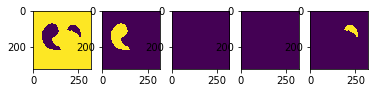

In [34]:
test = mask_1.get_data()[:,:,15]
img = mask_to_channels(test,0,5)
for i in range(0,5):
    plt.subplot(1,5,i+1)
    plt.imshow(img[:,:,i])
plt.show()

In [68]:
def create_data_train(train_ids = [1,2,3,5,8,10,13,19],background = 0):
    for idx, train_id in tqdm(enumerate(train_ids)):
        image, mask = read_train_exam(train_id)     
        image = preprocess(image)
        mask = preprocess(mask) 
        #transform le mask
        if background:
            #create mask for 5 classess
            mask = mask_to_channels(mask,0,5)[0]
        else:
            mask = mask_to_channels(mask,1,5)[0]            
       
        if idx > 0:
            train_data = np.concatenate((train_data, image),axis=0)
            train_mask = np.concatenate((train_mask, mask),axis=0)
        else:
            train_data = image
            train_mask = mask
    print("Final shape {},{}".format(train_data.shape,train_mask.shape))    
    np.savez_compressed('./dataset/imgs_train_{}'.format(background), imgs=train_data)
    np.savez_compressed('./dataset/imgs_mask_train_{}'.format(background), imgs_mask=train_mask)

In [46]:
#dataset training without background
create_data_train()

1it [00:00,  3.35it/s]

(1, 36, 256, 256, 4)


2it [00:00,  3.18it/s]

(1, 26, 256, 256, 4)


3it [00:01,  2.44it/s]

(1, 30, 256, 256, 4)


4it [00:01,  2.46it/s]

(1, 30, 256, 256, 4)


5it [00:02,  2.29it/s]

(1, 32, 256, 256, 4)
(1, 36, 256, 256, 4)


6it [00:02,  2.14it/s]

(1, 30, 256, 256, 4)


7it [00:03,  1.94it/s]

(1, 30, 256, 256, 4)


8it [00:04,  1.71it/s]


Final shape (250, 256, 256, 1),(250, 256, 256, 4)


In [48]:
#dataset training without background
create_data_train(background=1)

1it [00:00,  3.06it/s]

(1, 36, 256, 256, 5)


2it [00:00,  2.92it/s]

(1, 26, 256, 256, 5)


3it [00:01,  2.61it/s]

(1, 30, 256, 256, 5)


4it [00:01,  2.50it/s]

(1, 30, 256, 256, 5)
(1, 32, 256, 256, 5)


5it [00:02,  2.23it/s]

(1, 36, 256, 256, 5)


6it [00:02,  2.03it/s]

(1, 30, 256, 256, 5)


7it [00:03,  1.84it/s]

(1, 30, 256, 256, 5)


8it [00:04,  1.68it/s]


Final shape (250, 256, 256, 1),(250, 256, 256, 5)


### plot images

In [52]:
img = np.load('./dataset/imgs_train_0.npz')['imgs']
img_mask = np.load('./dataset/imgs_mask_train_0.npz')['imgs_mask']

In [53]:
img[:,:,:].shape

(250, 256, 256, 1)

In [54]:
img[:,:,:,0].shape

(250, 256, 256)

In [58]:
#plot random samples from data
def plot_random_images(data,mask,size,id):
    index = np.random.choice(range(data.shape[0]),size)
    plt.figure(figsize=(20, 15))
    for i,x in enumerate(index):
        plt.subplot(1, len(index), i+1)
        plt.imshow(data[x,:,:,0], cmap='gray', interpolation='nearest')
        plt.imshow(mask[x,:,:,id], cmap='jet', alpha=0.5)
    plt.show()

Training data


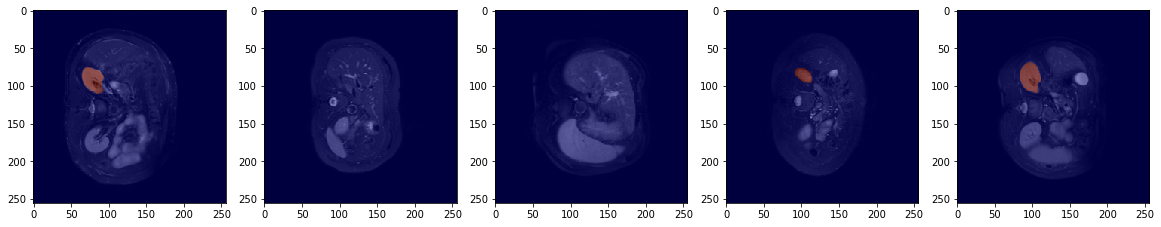

In [59]:
#plot random samples from training data
print("Training data")
plot_random_images(img,img_mask,5,1)

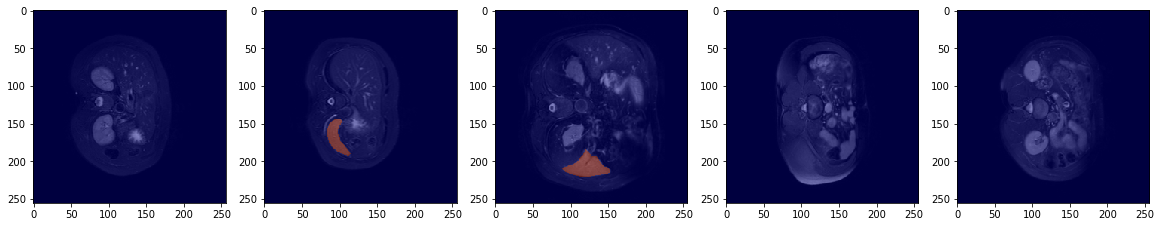

In [62]:
plot_random_images(img,img_mask,5,3)

In [66]:
print(np.unique(img))

[0.00000000e+00 1.00974196e-28 1.51461294e-28 ... 2.02000000e+03
 2.04100000e+03 2.04300000e+03]


In [64]:
imgs_train = img.astype('float32')
mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization

imgs_train -= mean
imgs_train /= std

In [67]:
print(np.unique(imgs_train))

[-0.53052306 -0.53049946 -0.53047585 ... 11.664149   11.790925
 11.8029995 ]


### test

In [69]:
def get_data_test(test_ids = [21,22,32,39]):
    for idx, test_id in tqdm(enumerate(test_ids)):
        image = read_test_exam(test_id)     
        image = preprocess(image)
        print("img {}".format(image.shape))
        if idx > 0:
            test_data = np.concatenate((test_data, image),axis=0)
        else:
            test_data = image
    print("Final shape {}".format(test_data.shape))    
    np.savez_compressed('./dataset/imgs_test', imgs=test_data)

In [70]:
get_data_test()

2it [00:00,  8.78it/s]

img (31, 256, 256, 1)
img (33, 256, 256, 1)


4it [00:00,  8.10it/s]

img (39, 256, 256, 1)
img (26, 256, 256, 1)
Final shape (129, 256, 256, 1)


# MODEL

In [2]:
#version tf1
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as K


from data import load_train_data, load_test_data

K.set_image_data_format('channels_last')  # TF dimension ordering in this code

Using TensorFlow backend.


In [3]:
img_rows = 256
img_cols = 256

In [6]:
smooth = 1.
#batch 32!
def dice_coef_(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef(y_true, y_pred):
    dice_liver = dice_coef_(y_true[0,:,:,0],y_pred[0,:,:,0])
    dice_rkidney = dice_coef_(y_true[0,:,:,1], y_pred[0,:,:,1])
    dice_lkidney = dice_coef_(y_true[0,:,:,2], y_pred[0,:,:,2])
    dice_spleen = dice_coef_(y_true[0,:,:,3], y_pred[0,:,:,3])
    #return dice_liver + (dice_rkidney+dice_lkidney)+dice_spleen
    return dice_liver+dice_rkidney+dice_lkidney+dice_spleen

def dice_coef_loss(y_true, y_pred):  
    return -dice_coef(y_true, y_pred)


In [11]:
def get_unet():
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(4,(1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    #Adam(lr=1e-5)
    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef_])

    return model


In [147]:
from data import load_train_data, load_test_data

# training

In [12]:

#name = 'model_test_dice-80.h5' #medio funcional, adam 1e-5, loss=dice_coef_loss, metrics=[dice_coef]
name = 'model_test_dice_sum.h5'
checkpoint = ModelCheckpoint(name, verbose=1, save_best_only=True, save_weights_only=True)
model = get_unet()
model.summary()

Loading and preprocessing train data...
------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_21[0][0]                  
______________________________________

In [13]:
print('Loading and preprocessing train data...')
print('-'*30)
imgs_train, imgs_mask_train = load_train_data()
imgs_train = imgs_train.astype('float32')
mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization
imgs_train -= mean
imgs_train /= std
print("normalize")
np.savez_compressed('scaler',mean=mean,std=std)

results = model.fit(imgs_train, imgs_mask_train, batch_size=32, epochs=100, callbacks=[checkpoint],shuffle=True,
              validation_split=0.2)

normalize
Train on 200 samples, validate on 50 samples
Epoch 1/100
200/200 [==============================] - 5s 25ms/step - loss: -0.0886 - dice_coef_: 0.0222 - val_loss: -0.0563 - val_dice_coef_: 0.0208

Epoch 00001: val_loss improved from inf to -0.05629, saving model to model_test_dice_sum.h5
Epoch 2/100
200/200 [==============================] - 4s 18ms/step - loss: -0.1147 - dice_coef_: 0.0222 - val_loss: -0.0564 - val_dice_coef_: 0.0209

Epoch 00002: val_loss improved from -0.05629 to -0.05644, saving model to model_test_dice_sum.h5
Epoch 3/100
200/200 [==============================] - 4s 19ms/step - loss: -0.0957 - dice_coef_: 0.0223 - val_loss: -0.0566 - val_dice_coef_: 0.0209

Epoch 00003: val_loss improved from -0.05644 to -0.05659, saving model to model_test_dice_sum.h5
Epoch 4/100
200/200 [==============================] - 4s 19ms/step - loss: -0.0672 - dice_coef_: 0.0223 - val_loss: -0.0567 - val_dice_coef_: 0.0210

Epoch 00004: val_loss improved from -0.05659 to -0.0567

Epoch 34/100
200/200 [==============================] - 4s 19ms/step - loss: -0.1726 - dice_coef_: 0.0240 - val_loss: -0.0627 - val_dice_coef_: 0.0230

Epoch 00034: val_loss improved from -0.06198 to -0.06267, saving model to model_test_dice_sum.h5
Epoch 35/100
200/200 [==============================] - 4s 19ms/step - loss: -0.1222 - dice_coef_: 0.0243 - val_loss: -0.0633 - val_dice_coef_: 0.0233

Epoch 00035: val_loss improved from -0.06267 to -0.06330, saving model to model_test_dice_sum.h5
Epoch 36/100
200/200 [==============================] - 4s 19ms/step - loss: -0.1061 - dice_coef_: 0.0245 - val_loss: -0.0636 - val_dice_coef_: 0.0235

Epoch 00036: val_loss improved from -0.06330 to -0.06363, saving model to model_test_dice_sum.h5
Epoch 37/100
200/200 [==============================] - 4s 19ms/step - loss: -0.1004 - dice_coef_: 0.0247 - val_loss: -0.0643 - val_dice_coef_: 0.0239

Epoch 00037: val_loss improved from -0.06363 to -0.06427, saving model to model_test_dice_sum.h5
Epoc


Epoch 00068: val_loss did not improve from -0.36450
Epoch 69/100
200/200 [==============================] - 4s 18ms/step - loss: -0.1610 - dice_coef_: 0.0531 - val_loss: -0.2507 - val_dice_coef_: 0.0555

Epoch 00069: val_loss did not improve from -0.36450
Epoch 70/100
200/200 [==============================] - 4s 19ms/step - loss: -0.2982 - dice_coef_: 0.0554 - val_loss: -0.3391 - val_dice_coef_: 0.0571

Epoch 00070: val_loss did not improve from -0.36450
Epoch 71/100
200/200 [==============================] - 4s 18ms/step - loss: -0.3343 - dice_coef_: 0.0496 - val_loss: -0.3862 - val_dice_coef_: 0.0464

Epoch 00071: val_loss improved from -0.36450 to -0.38621, saving model to model_test_dice_sum.h5
Epoch 72/100
200/200 [==============================] - 4s 20ms/step - loss: -0.4208 - dice_coef_: 0.0480 - val_loss: -0.4157 - val_dice_coef_: 0.0509

Epoch 00072: val_loss improved from -0.38621 to -0.41573, saving model to model_test_dice_sum.h5
Epoch 73/100
200/200 [===================

# name = 'model_test_dice_sum.h5'


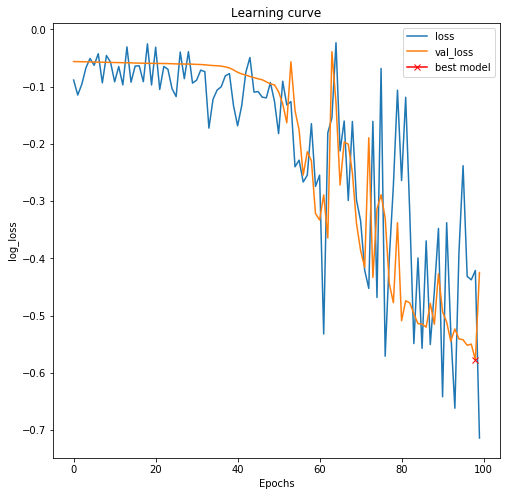

In [14]:
#meme poids
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

# evaluation

In [15]:
model = get_unet()
model.summary()
model.load_weights(name)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 32) 320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_39[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_40[0][0]                  
__________________________________________________________________________________________________
conv2d_41 

In [37]:
print('Loading and preprocessing train data...')
print('-'*30)
imgs_train, imgs_mask_train = load_train_data()

Loading and preprocessing train data...
------------------------------


In [49]:
id = 25
test = imgs_train[id,:,:,:]
test -= mean
test /= std
y_pred = model.predict(test.reshape(1,256,256,1))

# results

3.633261e-30 1.0
0.50613755 1.0
3.3328244e-21 0.99941814
7.722349e-12 0.99950683


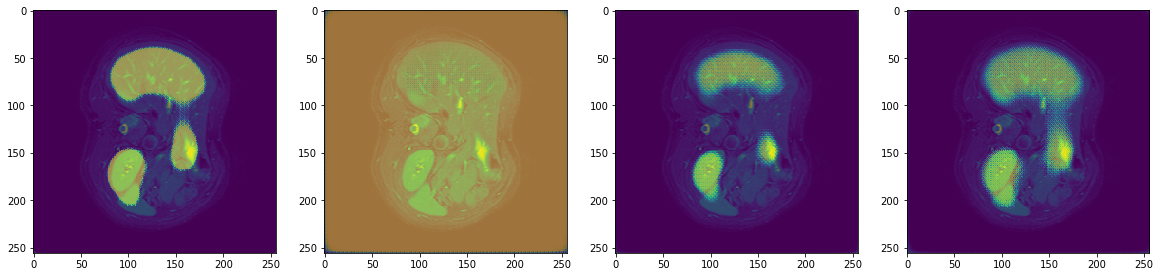

In [50]:
plt.figure(figsize=(20, 15))

for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(imgs_train[id,:,:,0])
    slice_ = y_pred[0,:,:,i]
    print(slice_.min(), slice_.max())
    plt.imshow(slice_,vmin = slice_.min(), vmax= slice_.max(),alpha=0.5)
plt.show()

# real

<function matplotlib.pyplot.show(*args, **kw)>

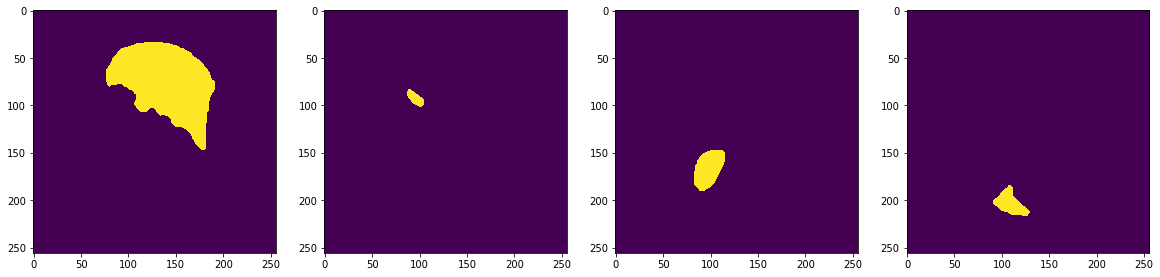

In [51]:
plt.figure(figsize=(20, 15))
for i in range(4):
    plt.subplot(1,4,i+1)
    slice_ = imgs_mask_train[id,:,:,i]
    #plt.imshow(imgs_train[id,:,:,0])
    plt.imshow(slice_)    
plt.show

# image test

In [32]:
imgs_test = load_test_data()
imgs_test -= mean
imgs_test /= std

In [33]:
mask_predicts = model.predict(imgs_test)

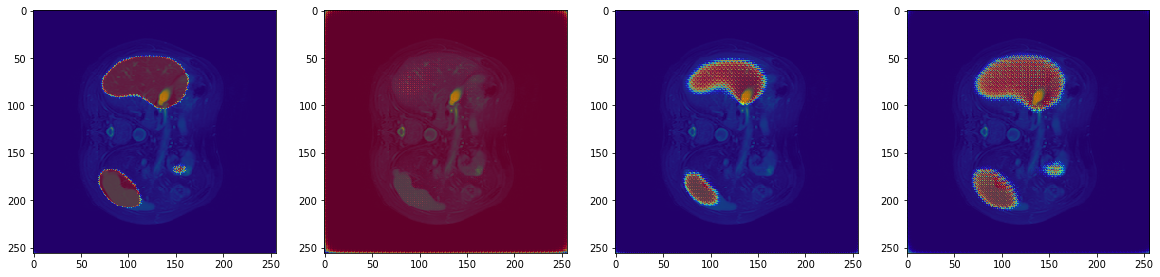

In [34]:
idx = 50
plt.figure(figsize=(20, 15))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(imgs_test[idx,:,:,0])
    slice_ = mask_predicts[idx,:,:,i]
    plt.imshow(slice_,vmin = slice_.min(), vmax= slice_.max(),cmap='jet', alpha=0.5)
plt.show()

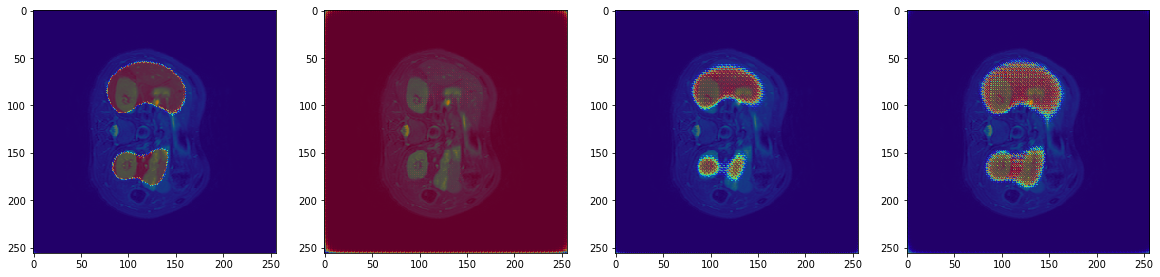

In [35]:
idx = 15
plt.figure(figsize=(20, 15))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(imgs_test[idx,:,:,0])
    slice_ = mask_predicts[idx,:,:,i]
    plt.imshow(slice_,vmin = slice_.min(), vmax= slice_.max(),cmap='jet', alpha=0.5)
plt.show()